In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
import pprint

In [5]:
!pip install  --no-dependencies  git+https://github.com/j-bac/elpigraph-python.git

  Cloning https://github.com/j-bac/elpigraph-python.git to /tmp/pip-req-build-x8exngd7
  Created wheel for elpigraph-python: filename=elpigraph_python-0.1.0-py3-none-any.whl size=86889 sha256=fd9a0d66e0b8969148d46b710dc22b40878b73e49a12cb49c5ae62960a649b05
  Stored in directory: /tmp/pip-ephem-wheel-cache-bk43sn2i/wheels/79/fc/a4/52027e414f1ebe30d37db5ece4b4cd1680fa35b6e256bbf356
Successfully built elpigraph-python


In [6]:
import elpigraph


In [7]:
#from sklearn.cluster import DBSCAN, KMeans, OPTICS, SpectralClustering
from sklearn.cluster import  KMeans,  SpectralClustering # DBSCAN, OPTICS,
import umap
import numpy as np
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.decomposition import PCA

def create_tree_by_cluster_knn_mst(X, n_clusters='sqrt', n_neighbors= 10,   verbose =  0, clustering_method = 'Kmeans' ):
  '''
  # Calcuates a tree approximation for given dataset X, by kmeans+knn+mst
  # 
  #' @param n_clusters number of clusters for clustering or 'sqrt' - square root of dataset size
  #' @param n_neighbors used by knn-graph step
  #
  #' @return
  # dict_result - dictionary with results:
  #   dict_result['csr_mst'] # adjancy matrix of MST graph in csr format (column sparse matrix - scipy )
  #   dict_result['edges_mst'] # edges matrix of MST graph, shape = n_nodes X 2 , each row contains ends of the correspoding edges
  #   dict_result['nodes_positions']  graph nodes positions
  #   dict_result['predicted_clusters'] vector with cluster number for each point of  input X
  #   dict_result['csr_knn'] same as 'csr_mst', but for intermediate knn-graph  
  #   dict_result['edges_knn'] same as 'edges_mst', but for intermediate knn-graph 
  # 
  #' @examples
  # X = np.random.rand(1000,10)
  # dict_result =  create_tree_by_cluster_knn_mst(X)# - Calcuates a tree for given dataset, by kmeans+knn+mst
  # edges =  dict_result['edges_mst']
  # nodes_positions = dict_result['nodes_positions']
  # plot_graph(edges, nodes_positions, data = X)
  # plt.show()  
  '''
  if n_clusters == 'sqrt':
    n_clusters = int( np.sqrt(X.shape[0] ) ) 

  #print("clustering_method.lower() == 'Spectral'.lower()", clustering_method.lower() == 'Spectral'.lower() )
  if isinstance(clustering_method ,str) and ( clustering_method.lower() == 'Spectral'.lower() ):
    clustering = SpectralClustering(n_clusters=n_clusters, random_state=0).fit(X)
    predicted_clusters = clustering.labels_ # kmeans.predict(X)
    # Get cluster centers by averaging:
    l = len(np.unique(predicted_clusters))
    cluster_centers_ = np.zeros( (l, X.shape[1]))
    for i,v in  enumerate(np.unique(predicted_clusters)):
      m = predicted_clusters==v 
      cluster_centers_[i,:] = np.mean(X[m,:],axis = 0 )
  else: # Kmeans clustering by defualt:
    clustering = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    cluster_centers_ = clustering.cluster_centers_
  predicted_clusters = clustering.labels_ # kmeans.predict(X)

  if verbose >= 100:
    print('cluster_centers_[:2,:]', cluster_centers_[:2,:])
    print('predicted_clusters.shape', predicted_clusters.shape)
    print('predicted_clusters[:2]', predicted_clusters[:2])

  # sklearn.neighbors.kneighbors_graph(X, n_neighbors, mode='connectivity', metric='minkowski', p=2, metric_params=None, include_self=False, n_jobs=None)[source]¶
  if n_neighbors > len(cluster_centers_):
    n_neighbors = len(cluster_centers_) # To avoid exception for small number of clusters 
  csr_knn = kneighbors_graph(cluster_centers_, n_neighbors= n_neighbors, mode= 'distance', include_self=True) # mode=  'connectivity'
  if verbose >= 100:
    print('csr_knn', type(csr_knn), csr_knn.shape)

  csr_mst = minimum_spanning_tree(csr_knn)
  if verbose >= 100:
    print('csr_mst', type(csr_mst),csr_mst.shape)

  dict_result = {}
  dict_result['csr_mst'] = csr_mst
  dict_result['csr_knn'] = csr_knn
  dict_result['nodes_positions'] = cluster_centers_
  dict_result['predicted_clusters'] = predicted_clusters
  dict_result['edges_mst'] = get_edges_from_adj_matrix( csr_mst )
  dict_result['edges_knn'] = get_edges_from_adj_matrix( csr_knn )

  return dict_result

def get_edges_from_adj_matrix( adj_matrix ):
  '''
  #' From adjacency matrix construct an edge list
  #' either [k1,k2]!=0 or [k2,k1]!=0, causes edge (k1,k2)
  #'
  #' @param  adj_matrix - adjacency matrix of an unoriented graph
  #'
  #' @return numpy.ndarray of shape Nx2, containing vertices for each edge 
  #'    
  #' @examples
  #' adj_matrix = np.array([[0,1,1],[0,0,0],[0,2,0]])
  #' edges = get_edges_from_adj_matrix( adj_matrix )
  '''
  list_edges = []
  n_vertex = adj_matrix.shape[0]
  for k1 in range(  n_vertex  ) :
    for k2 in range(k1, n_vertex ) :
      if ( adj_matrix[k1,k2] != 0) or (adj_matrix[k2,k1] != 0):
          list_edges.append( (k1,k2) )
  return np.array(list_edges)

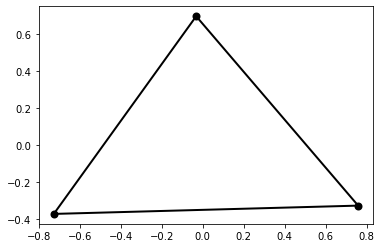

In [8]:
from sklearn.decomposition import PCA
try :
    import umap
except:
    print('cannot import umap')

def plot_graph(edges, nodes_positions, data = None, dim_reduction = 'PCA', graph_color = 'black', graph_linewidth=2, 
               plot_data = True, data_linewidth = 1,  data_color = 'tab:red', data_transparency_alpha = 0.9,
               umap_n_neighbors = 50, umap_min_dist = 0.99):
  '''
  #' Plots graphs defined by edges and nodes_positions, optionally - scatter plot the "data" on the same plot,
  #' Optionally performs PCA/etc (depending on dim_reduction)
  #'
  #' @param edges Nx2-shape matrix with edges ends, i.e. edges[k,0], edges[k,1] - ends of k-th edge  
  #' @param nodes_positions  matrix of nodes positions 
  #' @param data  "original dataset", basically arbitrary dataset for scatter plot, it should have same shape[1] as nodes_positions
  #' @param plot_data  True/False - to scatterplot or not data
  #' @param dim_reduction  'PCA', 'plot_first2axis', 'umap'
  #' @param data_color can be a vector or predefined color - argument for c = data_color in scatter

  #' @examples
  # edges = np.array([ [0,1],[1,2],[2,0] ] )
  # nodes_positions = np.random.rand(3,10) # 3 points in 10d space
  # plot_graph(edges, nodes_positions)
  #
  # t = elpigraph_output
  # edges = t[0]['Edges'][0]
  # nodes_positions = t[0]['NodePositions']
  # plot_graph(edges, nodes_positions)
  '''
  str_dim_reduction = dim_reduction
  if dim_reduction in ['PCA', 'umap' ]: #  not 'plot_first2axis':
    if dim_reduction.upper() == 'PCA':
      reducer = PCA()
    elif dim_reduction.lower() == 'umap':
      n_neighbors = umap_n_neighbors#  50
      min_dist= umap_min_dist # 0.99
      #n_components=n_components
      reducer = umap.UMAP( n_neighbors=n_neighbors,        min_dist=min_dist, n_components = 2)

    if data is not None:
      data2 = reducer.fit_transform(data)
      if plot_data == True:
        if data_color is None:
          plt.scatter(data2[:,0],data2[:,1], linewidth = data_linewidth , alpha = data_transparency_alpha)# ,cmap=plt.cm.Paired) # ,c=np.array(irx) 
          plt.xlabel(str_dim_reduction+'1')
          plt.ylabel(str_dim_reduction+'2')
        else:
          plt.scatter(data2[:,0],data2[:,1] ,cmap=plt.cm.Paired,c= data_color, linewidth = data_linewidth, alpha = data_transparency_alpha ) 
          plt.xlabel(str_dim_reduction+'1')
          plt.ylabel(str_dim_reduction+'2')
    else:
      reducer.fit(nodes_positions)

    nodes_positions2 = reducer.transform( nodes_positions )
  else:
    if plot_data == True:
      if data is not None:
        if data_color is None:
          plt.scatter(data[:,0],data[:,1] , linewidth = linewidth, alpha = data_transparency_alpha )# ,cmap=plt.cm.Paired) # ,c=np.array(irx) 
        else:
          plt.scatter(data[:,0],data[:,1] ,cmap=plt.cm.Paired,c= data_color , linewidth = data_linewidth, alpha = data_transparency_alpha ) 
    nodes_positions2 = nodes_positions

  plt.scatter(nodes_positions2[:,0],nodes_positions2[:,1],c = graph_color, linewidth = graph_linewidth)#, cmap=plt.cm.Paired)

  edgeCount = edges.shape[0]
  for k in range(edgeCount):
    n0 = edges[k,0]
    n1 = edges[k,1]
    x_line = [ nodes_positions2[n0,0],  nodes_positions2[n1,0] ]
    y_line = [ nodes_positions2[n0,1],  nodes_positions2[n1,1] ]
    plt.plot(x_line, y_line, graph_color, linewidth = graph_linewidth) # 'black')

    
edges = np.array([ [0,1],[1,2],[2,0] ] )
nodes_positions = np.random.rand(3,10) # 3 points in 10d space
plot_graph(edges, nodes_positions)    

In [17]:
import igraph
def partition_data(Xcp, NodePositions, MaxBlockSize = 10**6,SquaredXcp= None,
                  TrimmingRadius=float('inf')):
    '''
    # Partition the data by proximity to graph nodes
    # (same step as in K-means EM procedure)
    #
    # Inputs:
    #   X is n-by-m matrix of datapoints with one data point per row. n is
    #       number of data points and m is dimension of data space.
    #   NodePositions is k-by-m matrix of embedded coordinates of graph nodes,
    #       where k is number of nodes and m is dimension of data space.
    #   MaxBlockSize integer number which defines maximal number of
    #       simultaneously calculated distances. Maximal size of created matrix
    #       is MaxBlockSize-by-k, where k is number of nodes.
    #   SquaredX is n-by-1 vector of data vectors length: SquaredX = sum(X.^2,2);
    #   TrimmingRadius (optional) is squared trimming radius.
    #
    # Outputs
    #   partition is n-by-1 vector. partition[i] is number of the node which is
    #       associated with data point X[i, ].
    #   dists is n-by-1 vector. dists[i] is squared distance between the node with
    #       number partition[i] and data point X[i, ].
    '''
    if SquaredXcp is None:
      SquaredXcp = np.sum(Xcp**2,1)[:,np.newaxis]
    NodePositionscp = np.asarray(NodePositions)
    n = Xcp.shape[0]
    partition = np.zeros((n, 1), dtype=int)
    dists = np.zeros((n, 1))
    all_dists = np.zeros((n, NodePositions.shape[0] ))
    # Calculate squared length of centroids
    cent = NodePositionscp.T
    centrLength = (cent**2).sum(axis=0)
    # Process partitioning without trimming
    for i in range(0, n, MaxBlockSize):
        # Define last element for calculation
        last = i+MaxBlockSize
        if last > n:
            last = n
        # Calculate distances
        d = SquaredXcp[i:last] + centrLength-2*np.dot(Xcp[i:last, ], cent)
        tmp = d.argmin(axis=1)
        partition[i:last] = tmp[:, np.newaxis]
        dists[i:last] = d[np.arange(d.shape[0]), tmp][:, np.newaxis]
        all_dists[i:last,:] = d
    # Apply trimming
    if not np.isinf(TrimmingRadius):
        ind = dists > (TrimmingRadius**2)
        partition[ind] = -1
        dists[ind] = TrimmingRadius**2
    
    
    return np.asarray(partition), np.asarray(dists), np.asarray(all_dists)



def find_branches( graph, verbose = 0 ):
  '''
  #' Computes "branches" of the graph, i.e. paths from branch vertex (or terminal vertex)  to branch vertex (or terminal vertex)
  #' Can process disconnected graphs. Stand-alone point - is "branch".
  #' Circle is exceptional case - each circle (can be several connected components) is "branch"
  #'
  #' @param g - graph (igraph) 
  #' @param verbose - details output
  #' 
  #' @examples
  #' import igraph
  #' g = igraph.Graph.Lattice([3,3], circular = False ) 
  #' dict_output = find_branches(g, verbose = 1000)
  #' print( dict_output['branches'] )
  '''
  #verbose = np.inf
  #
  g = graph
  n_vertices_input_graph =   g.vcount()  
  set_vertices_input_graph = set( range( n_vertices_input_graph  ) ) 

  dict_output = {}
  #dict_output['branches'] = found_branches.copy()

  # Main variables for process: 
  found_branches = []
  processed_edges = []
  processed_vertices = set()

  ############################################################################################################################################
  # Connected components loop:
  count_connected_components = 0 
  while True: # Need loop if graph has several connected components, each iteration - new component
    count_connected_components += 1

    def find_start_vertex(g, processed_vertices ): 
      '''
      #' Find starting vertex for branches-search algorithm. 
      #' It should be either branching vertex (i.e. degree >2) or terminal vertex (i.e. degree 0 or 1), in special case when unprocessed part of graph is union of circles - processed outside function
      '''
      n_vertices = n_vertices_input_graph #  = g.count()# 
      if n_vertices == len( processed_vertices ):
        return -1,-1 # All vertices proccessed
      flag_found_start_vertex = 0 
      for v in set_vertices_input_graph: 
        if v in processed_vertices: continue
        if g.degree(v) != 2:
          flag_found_start_vertex = 1
          return v, flag_found_start_vertex
      return -1, 0 # All unprocessed vertices are of degree 2, that means graph is circle of collection or collection of circles

    ############################################################################################################################################
    # Starting point initialization. End process condtion.
    #
    # Set correctly the starting vertex for the algorithm
    # That should be branch vertex or terminal vertex, only in case graph is set of circles(disconnected) we take arbitrary vertex as initial, each circle will be a branch
    initial_vertex, flag_found_start_vertex = find_start_vertex(g, processed_vertices )
    if   flag_found_start_vertex > 0:
      current_vertex  = initial_vertex
    elif flag_found_start_vertex == 0: # All unprocessed vertices are of degree 2, that means graph is circle of collection or collection of circles
      # Take any unprocessed element 
      tmp_set = set_vertices_input_graph  - processed_vertices
      current_vertex = tmp_set.pop()
    else:
      # No vertices to process 
      if verbose >= 10:
        print('Process finished')
      dict_output['branches'] = found_branches.copy()
      return dict_output
      #break

    ############################################################################################################################################
    # Core function implementing "Breath First Search" like algorithm
    # with some updates in storage, since we need to arrange edges into "branches"
    def find_branches_core( current_vertex , previous_vertex, current_branch  ):
      core_call_count[0] = core_call_count[0] + 1
      if verbose >= 1000:
        print(core_call_count[0], 'core call.', 'current_vertex', current_vertex , 'previous_vertex', previous_vertex,'found_branches',found_branches, 'current_branch',current_branch )

      processed_vertices.add(current_vertex)
      neis = g.neighbors(current_vertex) 
      if len(neis) == 0: # current_vertex is standalone vertex
        found_branches.append( [current_vertex] )
        return 
      if len(neis) == 1: # current_vertex is terminal vertex
        if neis[0] == previous_vertex:
          current_branch.append( current_vertex  )
          found_branches.append( current_branch.copy() )
          # processed_edges.append(  set([current_vertex , previous_vertex])  )  
          return 
        else:
          # That case may happen if we just started from that vertex
          # Because it has one neigbour, but it is not previous_vertex, so it is None, which is only at start 
          current_branch = [current_vertex] # , neis[0] ] # .append( current_vertex  )
          processed_edges.append(  set([current_vertex , neis[0] ])  )
          find_branches_core( current_vertex = neis[0] , previous_vertex = current_vertex, current_branch = current_branch )  
          return
      if len(neis) == 2: # 
        # continue the current branch:
        current_branch.append( current_vertex  )
        next_vertex = neis[0]
        if next_vertex == previous_vertex: next_vertex = neis[1]
        if next_vertex in processed_vertices: # Cannot happen for trees, but may happen if graph has a loop
          if set([current_vertex , next_vertex]) not in processed_edges:
            current_branch.append( next_vertex  )
            found_branches.append( current_branch.copy() )
            processed_edges.append(  set([current_vertex , next_vertex])  )
            return 
          else:
            return
        processed_edges.append(  set([current_vertex , next_vertex])  )          
        find_branches_core( current_vertex=next_vertex , previous_vertex = current_vertex, current_branch = current_branch )
        return
      if len(neis)  > 2 : #Branch point
        if  previous_vertex is not None:
          # Stop current branch
          current_branch.append( current_vertex  )
          found_branches.append(current_branch.copy())
        for next_vertex in neis:
            if next_vertex ==  previous_vertex:    continue
            if next_vertex in  processed_vertices: # Cannot happen for trees, but may happen if graph has a loop
              if set([current_vertex , next_vertex]) not in processed_edges:
                processed_edges.append(  set([current_vertex , next_vertex])  )
                found_branches.append( [current_vertex, next_vertex ] )
              continue
            current_branch = [current_vertex]
            processed_edges.append(  set([current_vertex , next_vertex])  )
            find_branches_core( current_vertex = next_vertex , previous_vertex = current_vertex , current_branch = current_branch)
      return

    ############################################################################################################################################
    # Core function call. It should process the whole connected component
    if verbose >= 10:
      print('Start process count_connected_components', count_connected_components, 'initial_vertex', current_vertex)
    processed_vertices.add(current_vertex)
    core_call_count = [0]
    find_branches_core( current_vertex = current_vertex , previous_vertex = None , current_branch = [])

    ############################################################################################################################################
    # Output of results for connected component
    if verbose >=10:
      print('Connected component ', count_connected_components, ' processed ')
      print('Final found_branches',found_branches)
      print('N Final found_branches', len( found_branches) )


def branch_labler( X , graph, nodes_positions, verbose = 0 ):
  '''
  #' Labels points of the dataset X by "nearest"-"branches" of graph.
  #' 
  #'
  #' @examples
  # X = np.array( [[0.1,0.1], [0.1,0.2], [1,2],[3,4],[5,0]] )
  # nodes_positions = np.array( [ [0,0], [1,0], [0,1], [1,1] ]  ) 
  # import igraph
  # g = igraph.Graph(); g.add_vertices(  4  )
  # g.add_edges([[0,1],[0,2],[0,3]])
  # vec_labels_by_branches = branch_labler( X , g, nodes_positions )
  '''
  #####################################################################################
  # Calculate branches and clustering by vertices of graph 
  dict_output = find_branches(graph, verbose = verbose )
  if verbose >=100:
    print('Function find_branches results branches:',  dict_output['branches'] )
  vec_labels_by_vertices, dists, all_dists = partition_data(X, nodes_positions) # np.array([[1,2,3,4], [1,2,3,4], [1,2,3,4], [10,20,30,40]]), [[1,2,3,4], [10,20,30,40]], 10**6)#,SquaredX)
  vec_labels_by_vertices = vec_labels_by_vertices.ravel()
  if verbose >=100:
    print('Function partition_data returns: vec_labels_by_vertices.shape, dists.shape, all_dists.shape', vec_labels_by_vertices.shape, dists.shape, all_dists.shape )
  #####################################################################################

  n_vertices = len( nodes_positions)
  branches = dict_output['branches']

  #####################################################################################
  # Create dictionary vertex to list of branches it belongs to  
  dict_vertex2branches = {}
  for i,b in enumerate( branches):
    for v in b:
      if v in dict_vertex2branches.keys():
        dict_vertex2branches[v].append(i)
      else:
        dict_vertex2branches[v] = [i]
  if verbose >=100:
    print( 'dict_vertex2branches', dict_vertex2branches )


  #####################################################################################
  # create list of branch and non-branch vertices
  list_branch_vertices = []
  list_non_branch_vertices = []
  for v in dict_vertex2branches:
    list_branches = dict_vertex2branches[v]
    if len(list_branches) == 1:
      list_non_branch_vertices.append(v)
    else:
      list_branch_vertices.append(v)
  if verbose >=100:  
    print('list_branch_vertices, list_non_branch_vertices', list_branch_vertices, list_non_branch_vertices)

  #####################################################################################
  # First stage of creation of final output - create labels by branches vector 
  # After that step it will be only correct for non-branch points 
  vec_vertex2branch = np.zeros(  n_vertices  ) 
  for i in range( n_vertices  ):
    vec_vertex2branch[i] = dict_vertex2branches[i][0]
  vec_labels_by_branches = vec_vertex2branch[ vec_labels_by_vertices ] 
  if verbose >= 100:
    print('branches', branches)
    print('vec_labels_by_branches', vec_labels_by_branches)

  #####################################################################################
  # Second stage of creation of final output - 
  # make correct calculation for branch-vertices create labels by correct branches 
  for branch_vertex in list_branch_vertices:
    if verbose >= 100:
      print('all_dists.shape', all_dists.shape)
    def labels_for_one_branch_vertex( branch_vertex , vec_labels_by_vertices,  all_dists ):
      '''
      #' For the branch_vertex re-labels points of dataset which were labeled by it to label by "correct branch".
      #' "Correct branch" label is a branch 'censored'-nearest to given point. 
      #' Where 'censored'-nearest means the minimal distance between the point  and all points of the branch except the given branch_vertex
      #'
      #' Function changes vec_labels_by_branches defined above
      #' Uses vec_labels_by_vertices defined above - vector of same length as dataset, which contains labels by vertices 
      '''

      mask = vec_labels_by_vertices.ravel() == branch_vertex # Select part of the dataset which is closest to branch_vertex

      # Allocate memory for array: first coordinate - point of dataset[mask],  second coordinate - branch number , for all branches contianing given vertex (i.e. branch_vertex) 
      # For each point of dataset[mask] it contains 'censored'-distances to "branches" adjoint to "branch_vertex", 
      # 'censored' means minimal over vertices belonging to  distance to branches (excluding branch_vertex)
      dist2branches = np.zeros( [ mask.sum(), len(dict_vertex2branches[branch_vertex] )  ] )
      list_branch_ids = [] # that will be necessary to renumerate local number to branch_ids 
      for i,branch_id in enumerate( dict_vertex2branches[branch_vertex] ):
        list_branch_ids.append(branch_id)
        # Create list of vertices of current branch, with EXCLUSION of branch_vertex
        branch_vertices_wo_given_branch_vertex = [v for v in branches[branch_id] if v != branch_vertex ]
        # For all points of dataset[mask] calculate minimal distances to given branch (with exclusion of branch_point), i.e. mininal difference for  
        if verbose >= 1000:
          print('mask.shape, all_dists.shape', mask.shape, all_dists.shape)
        dist2branches[ : ,i ] = np.min( all_dists[mask,:][:,branch_vertices_wo_given_branch_vertex], 1 ).ravel()

      vec_labels_by_branches[mask] = np.array(list_branch_ids)[ np.argmin( dist2branches, 1) ]
    labels_for_one_branch_vertex( branch_vertex, vec_labels_by_vertices,  all_dists  )

    if verbose >= 10:    
      print('Output: vec_labels_by_branches', vec_labels_by_branches)


  return vec_labels_by_branches


(600, 2) (600,)


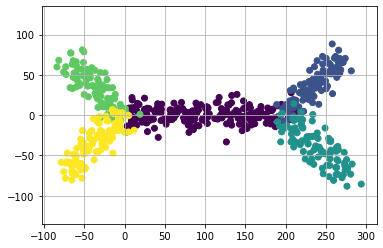

In [9]:
def make_dumbbell(n_layers = 1, n_features = 2,  sigma_noise = 10.0, n_samples4base = 200,
                  n_samples4branches = [100,100,100,100] , angles = [np.pi/4,-np.pi/4,3*np.pi/4,-3*np.pi/4] ):
  '''
  '''

  """
  n_layers = 2
  n_features = 2
  sigma_noise = 10.0
  plot_mode = 'PCA'
  n_samples4base = 200
  n_samples4branches = [100,100,100,100]
  angles = [np.pi/4,-np.pi/4,3*np.pi/4,-3*np.pi/4]
  """

  X_noiseless = np.zeros( (0,n_features))
  y_final = np.zeros( 0 )
  for layer in range(n_layers):
    current_label = 0 
    X = np.zeros( (n_samples4base, n_features) )
    X[:,0] = np.arange(n_samples4base)
    y = current_label * np.ones( n_samples4base )
    v_last_base_point_save = X[-1,:].copy()
    v_first_base_point_save = X[0,:].copy()

    # Make branches
    n_branches = len ( n_samples4branches )
    for c_branch in range( n_branches ) : # n_branches
      n_sample4branch = n_samples4branches[c_branch]
      current_label += 1
      y_branch = current_label * np.ones( n_sample4branch )
      angle = angles[c_branch] 
      if c_branch < n_branches/ 2:
        v_initial = v_last_base_point_save
      else:
        v_initial = v_first_base_point_save  
      X_branch = np.zeros( (n_sample4branch,  n_features)  ) #  [:2] = (np.cos(angle), np.sin(angle) )  
      v_direction = np.zeros( n_features)
      v_direction[0] = np.cos(angle)
      v_direction[1] = np.sin(angle)
      X_branch += v_direction # Broadcast vector to the whole array over axis 0 
      X_branch *= np.arange( 1, X_branch.shape[0] +1 ).reshape(X_branch.shape[0], 1 ) # Broadcast - mutiply each column by  by column = 1,2,3, ... 
      X_branch += v_initial # 
      X = np.concatenate( (X,X_branch) , axis = 0 )
      y = np.concatenate( (y, y_branch ))
    X_noiseless = np.concatenate( (X_noiseless,X) , axis = 0 )
    y_final = np.concatenate( (y_final,y) ) 
    
  X_noisy = X_noiseless + sigma_noise * np.random.randn( X_noiseless.shape[0], X_noiseless.shape[1] )


  y = y_final
  X = X_noisy

  if 0:
    print(X.shape, y.shape)
    r = X_noisy
    plt.scatter(r[:,0],r[:,1], c =y)
    plt.show()
  
  return X,y

X,y = make_dumbbell(n_layers = 1, n_features = 2,  sigma_noise = 10.0, n_samples4base = 200,
                  n_samples4branches = [100,100,100,100] , angles = [np.pi/4,-np.pi/4,3*np.pi/4,-3*np.pi/4] )
if 1:
  print(X.shape, y.shape)
  r = X
  plt.scatter(r[:,0],r[:,1], c =y)
  plt.axis("equal")
  plt.grid()
  plt.show()


(1050, 20) shape of output array X. (1050,) shape of output y
(1050, 20) (1050,)
[[ 149.            0.        ]
 [ 254.39978084 -111.23168267]
 [ 275.24728417  -80.50372448]]


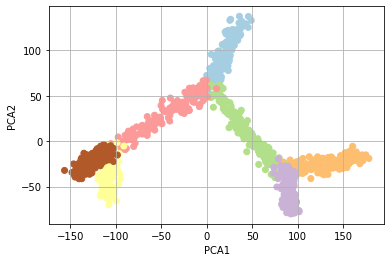

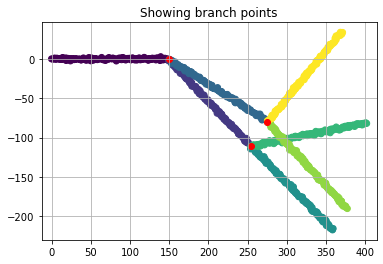

In [10]:
from sklearn.decomposition import  PCA

try:
    import umap 
except:
    print('cannot import umap - do not use plot_mode = "umap"')

def make_multi_level_fork(n_teeth = 2, len_tooth=100,
        n_components = 2, n_levels_of_branching = 2, inertia_coef = 0, 
        sigma_noise = 10.0,  teeth_start_distance = 0,  plot_mode = 'PCA',
        step_from_previous_branch = 0 , return_X_y = True ): 
  '''
  Returns numpy array containing image for multi-teeth fork,
  its shape is (len_tooth*(n_teeth+1) , 2  ) , 
  output y  - contains labels, which is teath number and zero for base of the fork
  
  @examples
  X = make_multi_level_fork()
  X = makemake_multi_level_fork_fork(n_teeth = 3, plot_mode = 'PCA' )
  '''

  """
  n_components = 5
  n_levels_of_branching = 2
  inertia_coef = 0
  n_teeth = 2
  len_tooth=100 
  tangent_step_between_teeth = 1 
  sigma_noise = 20.0
  teeth_start_distance = 0  
  plot_mode = 'PCA'
  """

  ## Prepare output variable - it is outputed if return_X_y = False and dicitionary is returned
  list_branch_points = []

  ################################################################################################
  # Prepare the "hand of fork" - the first branch which goes i*(1,0,0...0)+noise
  ################################################################################################
  current_label = 0
  n = len_tooth
  X = sigma_noise* np.random.randn(n, n_components) #np.zeros((n,n_components))
  X[:,0] = X[:,0] + np.arange(n)
  y = np.ones(n) * current_label
  current_label += 1
  X_final = X.copy()
  y_final = y.copy()

  ################################################################################################
  # Intialize "previous step" datum for main loop
  ################################################################################################
  last_point_of_previous_branch = np.zeros(n_components)
  last_point_of_previous_branch[0] = n-1  
  list_branch_points.append( last_point_of_previous_branch   )
  direction_vector = np.zeros(n_components)
  direction_vector[0] = 1

  list_last_point_of_previous_branch = []
  list_last_point_of_previous_branch.append( last_point_of_previous_branch  )
  list_previous_direction_vector = []
  list_previous_direction_vector.append( direction_vector  )

  new_list_last_point_of_previous_branch = [] 
  new_list_previous_direction_vector = []

  ################################################################################################
  # Main loop
  ################################################################################################
  for current_level in range(1,n_levels_of_branching):
    for i,last_point_of_previous_branch in enumerate(list_last_point_of_previous_branch):
      previous_direction_vector = list_previous_direction_vector[i]
      for teeth in range( int(n_teeth) ):# range( int(n_teeth/2)+1):
        v = np.random.randn(n_components)
        v = v / np.sqrt( np.sum(v**2) ) # Normilize
        v = v + inertia_coef*previous_direction_vector
        v = v / np.sqrt( np.sum(v**2) ) # Normilize

        X = np.zeros( (n, n_components) )
        X[0,:] = last_point_of_previous_branch + v + v*step_from_previous_branch
        for i in range(1, X.shape[0]):
          X[i,:] += X[i-1,:] + v

        new_list_last_point_of_previous_branch.append(  X[n-1, :] )
        if current_level < n_levels_of_branching - 1: # Last level is end , not branching
          list_branch_points.append( X[n-1, :]   )
        new_list_previous_direction_vector.append(v)

        X += sigma_noise* np.random.randn(n, n_components) #np.zeros((n,n_components))
        y = np.ones(n) * current_label
        current_label += 1

        X_final = np.concatenate((X_final,X), axis = 0)
        y_final = np.concatenate( (y_final, y) )

    list_last_point_of_previous_branch = new_list_last_point_of_previous_branch.copy() # n_levels_of_branching
    new_list_last_point_of_previous_branch = []
    list_previous_direction_vector = new_list_previous_direction_vector.copy()
    new_list_previous_direction_vector = []

  X = X_final
  y = y_final

  ################################################################################################
  # Plotters
  ################################################################################################
  if isinstance(plot_mode, str) and (plot_mode.lower() in ['pca'] ):
    try:
      from sklearn.decomposition import  PCA
      r = PCA().fit_transform(X)
      print(X.shape,'shape of output array X.', y.shape, 'shape of output y' )
      plt.scatter(r[:,0],r[:,1], c = y, cmap= plt.cm.Paired )  # cmp = 'viridis'
      plt.axis("equal")
      plt.xlabel('PCA1')
      plt.ylabel('PCA2')
      plt.grid()
      #plt.show()
    except:
      print('Exception - cannot plot PCA')
  elif isinstance(plot_mode, str) and (plot_mode.lower() in ['first_two_components'] ):
    print(X.shape,'shape of output array X.', y.shape, 'shape of output y' )
    plt.scatter(X[:,0],X[:,1], c = y, cmap= plt.cm.Paired )  # cmp = 'viridis'
    plt.axis("equal")
    plt.grid()
    #plt.show()
  elif isinstance(plot_mode, str) and (plot_mode.lower() in ['umap'] ):
    try:
      import umap
      r = umap.UMAP().fit_transform(X)
      print(X.shape,'shape of output array X.', y.shape, 'shape of output y' )
      plt.scatter(r[:,0],r[:,1], c = y, cmap= plt.cm.Paired )  # cmp = 'viridis'
      plt.axis("equal")
      plt.xlabel('UMAP1')
      plt.ylabel('UMAP2')
      plt.grid()
      #plt.show()
    except:
      print('Exception - cannot plot umap')
  elif isinstance(plot_mode, str) and (plot_mode.lower() in ['tsne'] ):
    try:
      from sklearn.manifold import TSNE
      r = TSNE().fit_transform(X)
      print(X.shape,'shape of output array X.', y.shape, 'shape of output y' )
      plt.scatter(r[:,0],r[:,1], c = y, cmap= plt.cm.Paired )  # cmp = 'viridis'
      plt.axis("equal")
      plt.grid()
      #plt.show()
    except:
      print('Exception - cannot plot TSNE')

  if return_X_y == True:
    return X,y
  else: # return "data" dictionary similar to sklearn load_iris, load_digits ... 
    data = {}
    data['data'] = X
    data['target'] = y
    data['DESCR'] = 'multi level fork'
    data['branch points'] = np.array( list_branch_points )
    return data

#####################################################################################
# First (simple ) use example 
#####################################################################################

X, y = make_multi_level_fork(sigma_noise = 5.0, len_tooth=150, n_components = 20, n_levels_of_branching = 3,
                                  inertia_coef = 0, step_from_previous_branch = 0, plot_mode = 'PCA') # 'PCA'
print(X.shape, y.shape)


#####################################################################################
# Second use example - show branch points 
#####################################################################################

data = make_multi_level_fork(sigma_noise = 1.0, len_tooth=150, n_components = 2, n_levels_of_branching = 3,
                                  inertia_coef = 1, step_from_previous_branch = 0, plot_mode = None, return_X_y = False) # 'PCA'
X = data['data']
y = data['target']
branch_points =  data['branch points']
print( branch_points )
if 1:
  r = X
  plt.figure()
  plt.scatter(r[:,0],r[:,1], c =y)
  for i in range(branch_points.shape[0]):
    p = branch_points[i,:]
    plt.scatter( p[0],p[1]  , c = 'red')
  plt.title('Showing branch points')
  plt.axis("equal")  
  plt.grid()
  plt.show()


In [11]:
from sklearn import metrics
import pandas as pd 

def compare_clusterings(y, y_pred, X = None,  df_report = None, df_report_colomn_name = None, list_scores = 'All'):
  if df_report is None:
    df_report = pd.DataFrame()
  if df_report_colomn_name  is None:
    df_report_colomn_name  = df_report.shape[1]+1
  
  list_scores_ids_require_ground_truth = ['adjusted_rand_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score',
                'homogeneity_score', 'completeness_score',  'v_measure_score', 'v_measure06_score', 'fowlkes_mallows_score',
                   ]
  list_scores_ids_not_require_ground_truth = ['inertia_score', 'silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score'  ]
  if list_scores == 'All':
    list_full = list_scores_ids_require_ground_truth + list_scores_ids_not_require_ground_truth
  else:
    list_full = list_scores

    
  def inertia_score(X, y):
    b = X.copy()
    for v in np.unique(y):
      #print(v)
      b[y==v,:] = np.mean(X[y==v,:],axis = 0) #[10,10])
    #print(b)
    return np.sum( np.sum( (X-b)**2 , 1) )  

  s = ''
  for score_id in list_full:
    #print(score_id)
    if (y is None) and (score_id in list_scores_ids_require_ground_truth):
        continue
    if score_id in list_scores_ids_require_ground_truth:
      if score_id not in ['v_measure06_score']:
        func_score  = getattr(metrics, score_id )
        m = func_score(y, y_pred)
      else:
        m = metrics.v_measure_score(y, y_pred, beta = 0.6)
    elif (score_id in list_scores_ids_not_require_ground_truth) and (X is not None):
      if score_id not in ['inertia_score']:
        if len(np.unique( y_pred )) > 1: # silu
          func_score  = getattr(metrics, score_id )
          m = func_score(X, y_pred)
        else:
          if score_id in ['silhouette_score',  'davies_bouldin_score']:
            m = 0
          elif score_id in ['calinski_harabasz_score']:
            m = np.inf
          else:
            # raise ValueError('unexpected score id')
            func_score  = getattr(metrics, score_id )
            m = func_score(X, y_pred)
      elif X is not None:
        m = inertia_score(X, y_pred)
    else:
      continue
    str_score_inf = score_id.replace('_score','') 
    #print(str_score_inf)
    s += str_score_inf + ' ' + ('%0.3f')%(m) + '\n'
    df_report.loc[str_score_inf, df_report_colomn_name ] = m

  return s,df_report 



15 0 0 sigma_noise, trial, total_count4sgm 3.30964724222819e-05  minutes passed

Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
2 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  40  nodes on  500  points and  2  dimensions
Nodes =  2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

2||40	272.0253	40	39	34	2	0	0	204.9689	194.0931	0.975	0.9763	63.7633	3.293	131.7213	5268.8506	0


3.2579  seconds elapsed

15 0 1 30 sigma_noise, cc, total_count,n_mst_nodes 0.0552759846051534  minutes passed

Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using

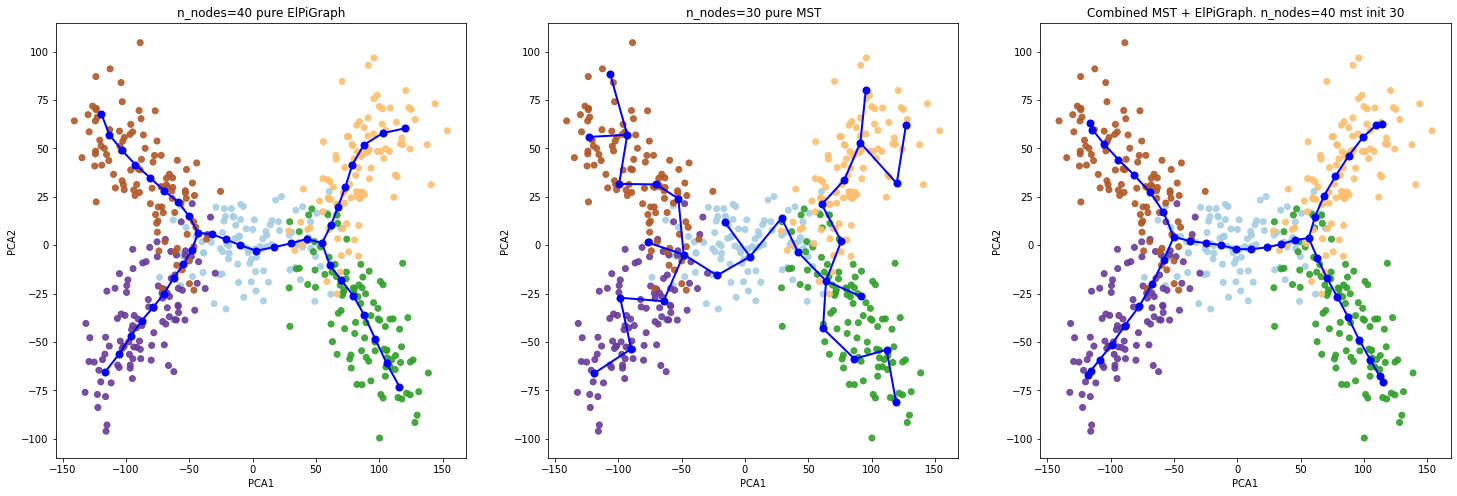

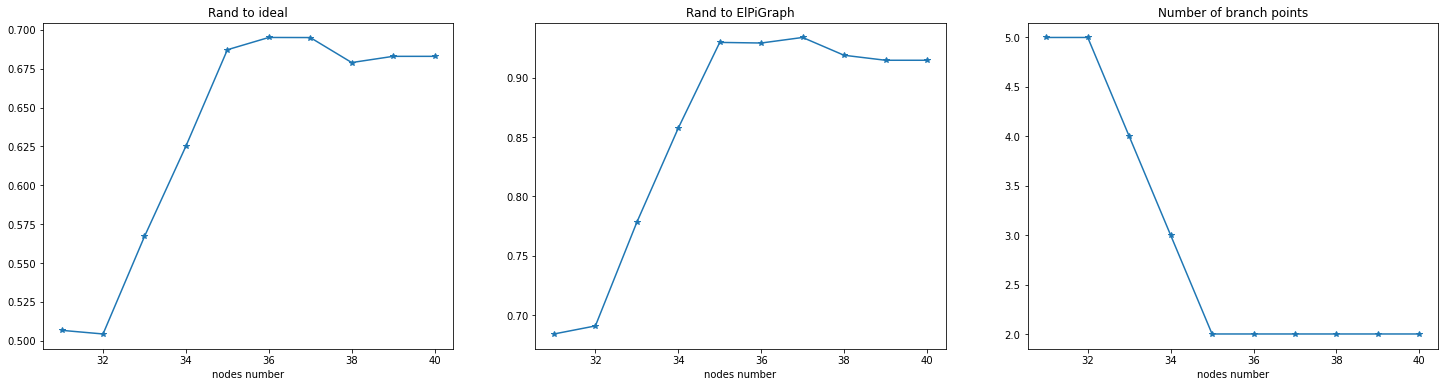

,Combined Noise sigma15 n_nodes_mst30 n_nodes31 trial0,Combined Noise sigma15 n_nodes_mst30 n_nodes32 trial0,Combined Noise sigma15 n_nodes_mst30 n_nodes33 trial0,Combined Noise sigma15 n_nodes_mst30 n_nodes34 trial0,Combined Noise sigma15 n_nodes_mst30 n_nodes35 trial0,Combined Noise sigma15 n_nodes_mst30 n_nodes36 trial0,Combined Noise sigma15 n_nodes_mst30 n_nodes37 trial0,Combined Noise sigma15 n_nodes_mst30 n_nodes38 trial0,Combined Noise sigma15 n_nodes_mst30 n_nodes39 trial0,Combined Noise sigma15 n_nodes_mst30 n_nodes40 trial0
adjusted_rand,0.506691,0.504345,0.567065,0.625200,0.687195,0.695096,0.695042,0.678958,0.682954,0.682954
mutual_info,1.174510,1.150692,1.100498,1.085174,1.097675,1.108373,1.108235,1.089664,1.094601,1.094601
adjusted_mutual_info,0.597334,0.597286,0.613520,0.640598,0.679356,0.686033,0.685991,0.674507,0.677520,0.677520
normalized_mutual_info,0.607008,0.606205,0.620935,0.646010,0.682586,0.689196,0.689155,0.677788,0.680769,0.680769
homogeneity,0.729764,0.714965,0.683778,0.674256,0.682024,0.688671,0.688585,0.677046,0.680114,0.680114
completeness,0.519603,0.526166,0.568671,0.620035,0.683149,0.689721,0.689725,0.678530,0.681426,0.681426
v_measure,0.607008,0.606205,0.620935,0.646010,0.682586,0.689196,0.689155,0.677788,0.680769,0.680769
v_measure06,0.633655,0.630171,0.635537,0.652848,0.682446,0.689064,0.689012,0.677602,0.680605,0.680605
fowlkes_mallows,0.598499,0.595278,0.647597,0.697311,0.749423,0.755741,0.755710,0.742884,0.746057,0.746057
inertia,292030.920511,315813.130955,396795.655903,460804.743075,517937.825532,517389.449092,516781.282389,516133.048190,517688.422456,517688.422456


In [66]:
import igraph

from sklearn import metrics

str_script_id = 'forkL3_combined_D20_I0_LT100_trials100_addBranchPtStat'

#os.listdir(dn) # test disk is mounted 

t0 = time.time()

df = pd.DataFrame()
df2_compare2pureElPiGraph = pd.DataFrame()

#n_clusters = 40
n_clusters_max_elpi = 40

for sigma_noise in [15]:#[30,20,10,5]:
  total_count = 0
  for cc in range(1):
    print()
    print(sigma_noise, cc, total_count,'sigma_noise, trial, total_count4sgm', (time.time() - t0)/60 , ' minutes passed' )
    print()

    total_count += 1

    #X,y = make_tube(n_samples=1000, n_features = 2, sigma_noise = sigma_noise, plot_mode = None)# 'PCA' )
    #X = np.random.rand(100,2)*10
    #X[:,0] += np.arange(100)
    n_samples4base = 100
    X,y = make_dumbbell(n_layers = 1, n_features = 2,  sigma_noise = sigma_noise, n_samples4base = n_samples4base,
            n_samples4branches = [100,100,100,100] , angles = [np.pi/4,-np.pi/4,3*np.pi/4,-3*np.pi/4] )

    if 0:
        data = make_multi_level_fork(sigma_noise = sigma_noise, len_tooth=100, n_components = 20, n_levels_of_branching = 3,
                                          inertia_coef = 0, step_from_previous_branch = 0, plot_mode = None, return_X_y = False) # 'PCA'
        X = data['data']
        y = data['target']
        true_branch_points =  data['branch points']
    
    #tree_elpi = elpigraph.computeElasticPrincipalTree(X , NumNodes=n_clusters,   drawPCAView=False,
    #  alpha=0.01,FinalEnergy='Penalized', StoreGraphEvolution = True )#,
    tree_elpi = elpigraph.computeElasticPrincipalTree(X ,  NumNodes=n_clusters_max_elpi,  # drawPCAView=False,
                  #InitNodePositions = nodes_positions,  InitEdges = edges,
                  alpha=0.01,FinalEnergy='Penalized', StoreGraphEvolution = True ) # ,                alpha=0.005,TrimmingRadius=0.3,FinalEnergy='Penalized')
    
    nodes_positions = tree_elpi[0]['NodePositions'] # ['AllNodePositions'][k]
    matrix_edges_weights = tree_elpi[0]['ElasticMatrix'] # ['AllElasticMatrices'][k]
    matrix_edges_weights = np.triu(matrix_edges_weights,1 )
    edges = np.array( np.nonzero(matrix_edges_weights), dtype = int ).transpose()

    g = igraph.Graph()
    g.add_vertices( len (nodes_positions ))
    g.add_edges(edges )
    vec_labels_by_branches_pure_elpi = branch_labler( X , g, nodes_positions )
    
    fig = plt.figure(figsize = (25,8) )
    fig.add_subplot(131)    
    plot_graph(edges, nodes_positions, data = X, data_color= y, graph_color=  'blue' )
    plt.title('n_nodes='+str(n_clusters)+' pure ElPiGraph')
    #plt.show()
    

    for n_mst_nodes in [30]: # [5, 10, 20,  40 , 60 , 80 , 95 ]:
      print()
      print(sigma_noise, cc, total_count,n_mst_nodes,'sigma_noise, cc, total_count,n_mst_nodes', (time.time() - t0)/60 , ' minutes passed' )
      print()

      dict_result =  create_tree_by_cluster_knn_mst(X, n_clusters= n_mst_nodes , n_neighbors= n_mst_nodes  )# - Calcuates a tree for given dataset, by kmeans+knn+mst
      edges =  dict_result['edges_mst']
      nodes_positions = dict_result['nodes_positions']
      edges_mst =  dict_result['edges_mst']
      nodes_positions_mst = dict_result['nodes_positions']
       
      fig.add_subplot(132)    
      plot_graph(edges, nodes_positions, data = X, data_color= y, graph_color=  'blue' )
      plt.title('n_nodes='+str(n_mst_nodes)+' pure MST')
      #plt.show()
        

      for n_clusters in [n_clusters_max_elpi]:
        total_count += 1

        #tree_elpi = elpigraph.computeElasticPrincipalTree(X , NumNodes=n_clusters,   drawPCAView=False,
        #  alpha=0.01,FinalEnergy='Penalized', StoreGraphEvolution = True )#,
        tree_elpi = elpigraph.computeElasticPrincipalTree(X ,  NumNodes=n_clusters,  # drawPCAView=False,
                      InitNodePositions = nodes_positions,  InitEdges = edges,
                      alpha=0.01,FinalEnergy='Penalized', StoreGraphEvolution = True ) # ,                alpha=0.005,TrimmingRadius=0.3,FinalEnergy='Penalized')
        
        if total_count <= 5:
          fig.add_subplot(133)    
            
          edges = tree_elpi[0]['Edges'][0]
          nodes_positions = tree_elpi[0]['NodePositions']
          plot_graph(edges, nodes_positions, data = X, data_color= y, graph_color=  'blue' )
          plt.title('Combined MST + ElPiGraph. n_nodes='+str(n_clusters)+' mst init '+ str(n_mst_nodes) )
          #plt.show()

        for k in range(n_mst_nodes+1, n_clusters+1  ):# 10

          #print(k)
          nodes_positions = tree_elpi[0]['AllNodePositions'][k]
          #plt.scatter(nodes_positions[:,0], nodes_positions[:,1])
          #print(np.sum(nodes_positions,0 ))
          matrix_edges_weights = tree_elpi[0]['AllElasticMatrices'][k]
          matrix_edges_weights = np.triu(matrix_edges_weights,1 )
          edges = np.array( np.nonzero(matrix_edges_weights), dtype = int ).transpose()
          #plot_graph(edges, nodes_positions, data = X ,  dim_reduction= None ) # graph_color= ['blue','green','red'][k-3] ,

          g = igraph.Graph()
          g.add_vertices( len (nodes_positions ))
          g.add_edges(edges )
          vec_labels_by_branches = branch_labler( X , g, nodes_positions )
          case_id = 'Combined'+' Noise sigma' +str( sigma_noise ) + ' n_nodes_mst'+str(n_mst_nodes) + ' n_nodes' + str(k) + ' trial'+str(cc)
          s,df = compare_clusterings(y,vec_labels_by_branches, X,  df , case_id )
          df.loc['n_branch pnts', case_id ] = np.sum(np.array(g.degree()) >= 3)
          df.loc['n_clusters', case_id ] = len(np.unique(vec_labels_by_branches))
          df.loc['n_components', case_id ] = len( list( g.components() ) )
          df.loc['n_nodes', case_id ] = k


          s,df2_compare2pureElPiGraph = compare_clusterings(vec_labels_by_branches_pure_elpi,vec_labels_by_branches, X,  df2_compare2pureElPiGraph , case_id )
          df2_compare2pureElPiGraph.loc['n_branch pnts', case_id ] = np.sum(np.array(g.degree()) >= 3)
          df2_compare2pureElPiGraph.loc['n_clusters', case_id ] = len(np.unique(vec_labels_by_branches))
          df2_compare2pureElPiGraph.loc['n_components', case_id ] = len( list( g.components() ) )
          df2_compare2pureElPiGraph.loc['n_nodes', case_id ] = k


        print( (time.time() - t0)/60 , ' minutes passed' )

        #if (total_count % 10) == 0 :
        #  df.to_pickle(dn + str_script_id +'_on_fly.pkl') 

plt.show()

df

fig = plt.figure(figsize = (25,6) )
fig.add_subplot(131)
x = df.loc['n_nodes',:]
v = df.loc['adjusted_rand',:]
plt.plot(x.values,v.values,'*-')
plt.title('Rand to ideal')
plt.xlabel('nodes number')
#plt.show()


fig.add_subplot(132)
x = df2_compare2pureElPiGraph.loc['n_nodes',:]
v = df2_compare2pureElPiGraph.loc['adjusted_rand',:]
plt.plot(x.values,v.values,'*-')
plt.title('Rand to ElPiGraph')
plt.xlabel('nodes number')
#plt.show()

fig.add_subplot(133)
x = df.loc['n_nodes',:]
v = df.loc['n_branch pnts',:]
plt.plot(x.values,v.values,'*-')
plt.title('Number of branch points')
plt.xlabel('nodes number')

plt.show()


df

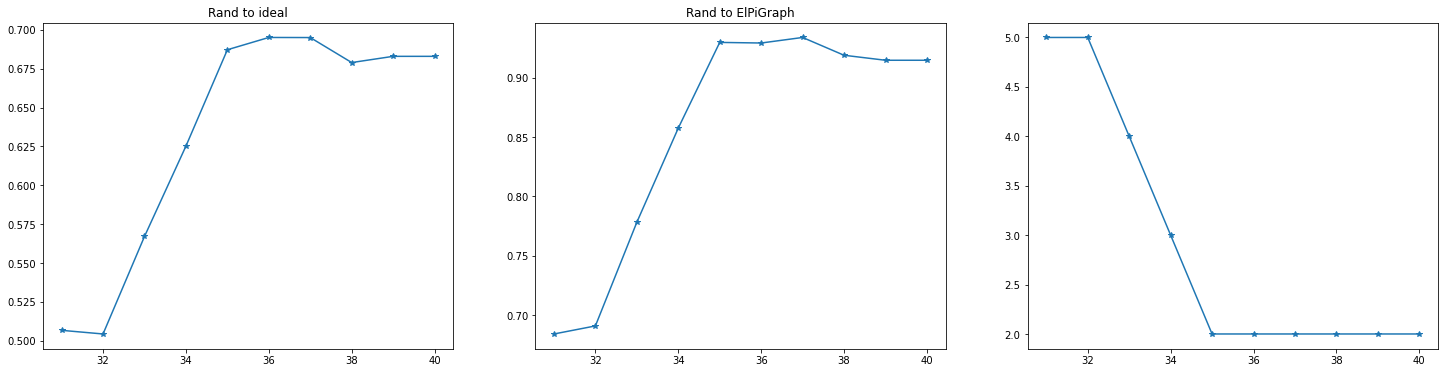

In [67]:
fig = plt.figure(figsize = (25,6) )
fig.add_subplot(131)
x = df.loc['n_nodes',:]
v = df.loc['adjusted_rand',:]
plt.plot(x.values,v.values,'*-')
plt.title('Rand to ideal')
#plt.show()


fig.add_subplot(132)
x = df2_compare2pureElPiGraph.loc['n_nodes',:]
v = df2_compare2pureElPiGraph.loc['adjusted_rand',:]
plt.plot(x.values,v.values,'*-')
plt.title('Rand to ElPiGraph')
#plt.show()

fig.add_subplot(133)
x = df.loc['n_nodes',:]
v = df.loc['n_branch pnts',:]
plt.plot(x.values,v.values,'*-')

plt.show()
